In [5]:
import io
from PIL import Image
import torch
import numpy

from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id

local_model_dir = "./detr-resnet-50-panoptic"

path = "./images/hq720.jpg"
image = Image.open(path)

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")
model.save_pretrained(local_model_dir)

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# use the `post_process_panoptic` method of `DetrFeatureExtractor` to convert to COCO format
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]

# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
# retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg)


c:\Users\elpulpo\Documents\Projects\COURS SIMPLON\ImageSegmentationTest\.venv\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForP

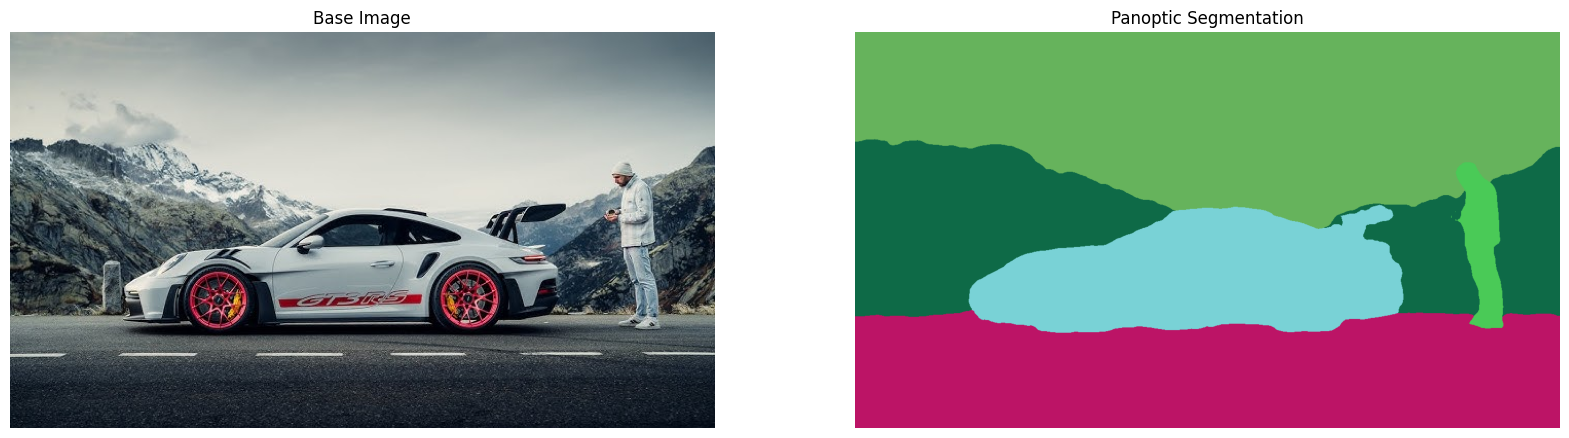

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a colorized image for the segmentation:
unique_ids = np.unique(panoptic_seg_id)
np.random.seed(42)  # For reproducibility
colors = {id: np.random.randint(0, 255, 3) for id in unique_ids}

# Create a colorized segmentation image
color_seg = np.zeros((panoptic_seg_id.shape[0], panoptic_seg_id.shape[1], 3), dtype=np.uint8)
for id in unique_ids:
    color_seg[panoptic_seg_id == id] = colors[id]

# Display side by side using subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Display the base image
ax[0].imshow(image)
ax[0].set_title("Base Image")
ax[0].axis('off')

# Display the colorized segmentation
ax[1].imshow(color_seg)
ax[1].set_title("Panoptic Segmentation")
ax[1].axis('off')

plt.show()


In [14]:
from PIL import Image

# Convert the PIL Image to a NumPy array
base_image_array = np.array(image)

# Affichage des shapes actuelles pour rappel
print("Base image shape (H, W, 3):", base_image_array.shape)  # (480, 640, 3)
print("Panoptic segmentation mask shape before resize:", panoptic_seg_id.shape)  # (800, 1066)

# Convert the segmentation mask (NumPy array) to a PIL Image.
# Ici, on s'assure que le masque est de type uint8 pour la conversion.
mask_pil = Image.fromarray(panoptic_seg_id.astype(np.uint8))

# Resize the mask to match the base image dimensions.
# Attention : Image.resize attend la taille au format (width, height)
resized_mask_pil = mask_pil.resize((base_image_array.shape[1], base_image_array.shape[0]),
                                   resample=Image.NEAREST)

# Convert the resized PIL image back to a NumPy array.
panoptic_seg_id = np.array(resized_mask_pil)
print("Panoptic segmentation mask shape after resize:", panoptic_seg_id.shape)


Base image shape (H, W, 3): (386, 686, 3)
Panoptic segmentation mask shape before resize: (750, 1333)
Panoptic segmentation mask shape after resize: (386, 686)


Unique segment IDs: [0 1 2 3 4]


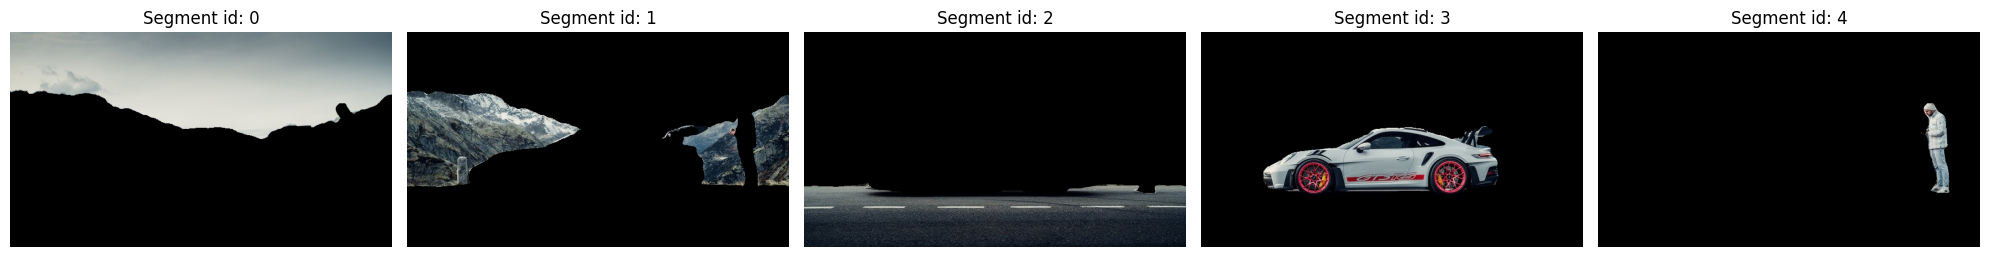

In [19]:
# Dictionary to store isolated segments
isolated_elements = {}

# Get unique segment IDs from the segmentation mask
unique_ids = np.unique(panoptic_seg_id)
print("Unique segment IDs:", unique_ids)

# Iterate over each segment id to isolate the corresponding part of the image
for seg_id in unique_ids:
    # Create a boolean mask: True where the pixel belongs to the current segment
    mask = panoptic_seg_id == seg_id

    # Copy the base image
    isolated = base_image_array.copy()

    # Set the pixels that are not part of the current segment to black
    isolated[~mask] = [0, 0, 0]
    
    # Store the isolated segment
    isolated_elements[seg_id] = isolated

# Display the isolated segments in a grid
import matplotlib.pyplot as plt

n_segments = len(unique_ids)
cols = min(n_segments, 5)  # adjust the number of columns as needed
rows = (n_segments + cols - 1) // cols  # number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = np.array(axs).reshape(-1)  # Flatten the axes array for easier iteration

for ax, seg_id in zip(axs, unique_ids):
    ax.imshow(isolated_elements[seg_id])
    ax.set_title(f"Segment id: {seg_id}")
    ax.axis('off')

# Turn off any extra axes if there are more subplots than segments
for ax in axs[n_segments:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
